In [31]:
# For this notebook to work, you need a huggingface account to download the weights for the model
# additionally, you'll need pytorch and a cuda enabled gpu with at least 10gb of ram, not counting vram for os and programs
# it is not reccomended to run this on the same machine you are streaming from

# output will overwite a stream.png image and stream.txt that you can point obs to

In [4]:
# # can comment this block out after first run
# !pip install --upgrade diffusers transformers scipy
# !huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Login successful
Your token has been saved to C:\Users\Alex/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [1]:
import socket, re, time
from emoji import demojize
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [2]:
# download model / load into ram

import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

use_half_precision = True

if use_half_precision:
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_auth_token=True)
else:
    pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=False)
pipe = pipe.to(device)

# uncomment at your own risk
# pipe.safety_checker = lambda images, clip_input: (images, [False] * len(images))
# should expand this with a few options, and add it into the callable interface instead of up here

In [3]:
import numpy as np
import torch
import torch.nn as nn

from transformers import CLIPConfig, CLIPVisionModel, PreTrainedModel

def cosine_distance(image_embeds, text_embeds):
    normalized_image_embeds = nn.functional.normalize(image_embeds)
    normalized_text_embeds = nn.functional.normalize(text_embeds)
    return torch.mm(normalized_image_embeds, normalized_text_embeds.T)


class StableDiffusionSafetyChecker(PreTrainedModel):
    config_class = CLIPConfig

    def __init__(self, config: CLIPConfig):
        super().__init__(config)

        self.vision_model = CLIPVisionModel(config.vision_config)
        self.visual_projection = nn.Linear(config.vision_config.hidden_size, config.projection_dim, bias=False)

        self.concept_embeds = nn.Parameter(torch.ones(17, config.projection_dim), requires_grad=False)
        self.special_care_embeds = nn.Parameter(torch.ones(3, config.projection_dim), requires_grad=False)

        self.register_buffer("concept_embeds_weights", torch.ones(17))
        self.register_buffer("special_care_embeds_weights", torch.ones(3))

    @torch.no_grad()
    def forward(self, clip_input, images):
        pooled_output = self.vision_model(clip_input)[1]  # pooled_output
        image_embeds = self.visual_projection(pooled_output)

        special_cos_dist = cosine_distance(image_embeds, self.special_care_embeds).cpu().numpy()
        cos_dist = cosine_distance(image_embeds, self.concept_embeds).cpu().numpy()

        result = []
        batch_size = image_embeds.shape[0]
        for i in range(batch_size):
            result_img = {"special_scores": {}, "special_care": [], "concept_scores": {}, "bad_concepts": []}

            # increase this value to create a stronger `nfsw` filter
            # at the cost of increasing the possibility of filtering benign images
            adjustment = 0.3

            for concet_idx in range(len(special_cos_dist[0])):
                concept_cos = special_cos_dist[i][concet_idx]
                concept_threshold = self.special_care_embeds_weights[concet_idx].item()
                result_img["special_scores"][concet_idx] = round(concept_cos - concept_threshold + adjustment, 3)
                if result_img["special_scores"][concet_idx] > 0:
                    result_img["special_care"].append({concet_idx, result_img["special_scores"][concet_idx]})
                    adjustment = 0.01

            for concet_idx in range(len(cos_dist[0])):
                concept_cos = cos_dist[i][concet_idx]
                concept_threshold = self.concept_embeds_weights[concet_idx].item()
                result_img["concept_scores"][concet_idx] = round(concept_cos - concept_threshold + adjustment, 3)
                if result_img["concept_scores"][concet_idx] > 0:
                    result_img["bad_concepts"].append(concet_idx)

            result.append(result_img)

        has_nsfw_concepts = [len(res["bad_concepts"]) > 0 for res in result]

        for idx, has_nsfw_concept in enumerate(has_nsfw_concepts):
            if has_nsfw_concept:
                images[idx] = np.zeros(images[idx].shape)  # black image

        if any(has_nsfw_concepts):
            print("Potential NSFW content was detected in one or more images. A black image will be returned instead.")

        return images, has_nsfw_concepts

In [4]:
import warnings
from collections import OrderedDict
from dataclasses import fields
from typing import Any, Tuple

import numpy as np

# from .import_utils import is_torch_available
def is_torch_available():
    return True 
# reaching peak fuck it attitude here with this snake ass of a convoluted bullshit withering worldtree of a directory structure just so I can change one freakn variable


def is_tensor(x):
    """
    Tests if `x` is a `torch.Tensor` or `np.ndarray`.
    """
    if is_torch_available():
        import torch

        if isinstance(x, torch.Tensor):
            return True

    return isinstance(x, np.ndarray)


class BaseOutput(OrderedDict):
    """
    Base class for all model outputs as dataclass. Has a `__getitem__` that allows indexing by integer or slice (like a
    tuple) or strings (like a dictionary) that will ignore the `None` attributes. Otherwise behaves like a regular
    python dictionary.
    <Tip warning={true}>
    You can't unpack a `BaseOutput` directly. Use the [`~utils.BaseOutput.to_tuple`] method to convert it to a tuple
    before.
    </Tip>
    """

    def __post_init__(self):
        class_fields = fields(self)

        # Safety and consistency checks
        if not len(class_fields):
            raise ValueError(f"{self.__class__.__name__} has no fields.")

        first_field = getattr(self, class_fields[0].name)
        other_fields_are_none = all(getattr(self, field.name) is None for field in class_fields[1:])

        if other_fields_are_none and not is_tensor(first_field):
            if isinstance(first_field, dict):
                iterator = first_field.items()
                first_field_iterator = True
            else:
                try:
                    iterator = iter(first_field)
                    first_field_iterator = True
                except TypeError:
                    first_field_iterator = False

            # if we provided an iterator as first field and the iterator is a (key, value) iterator
            # set the associated fields
            if first_field_iterator:
                for element in iterator:
                    if (
                        not isinstance(element, (list, tuple))
                        or not len(element) == 2
                        or not isinstance(element[0], str)
                    ):
                        break
                    setattr(self, element[0], element[1])
                    if element[1] is not None:
                        self[element[0]] = element[1]
            elif first_field is not None:
                self[class_fields[0].name] = first_field
        else:
            for field in class_fields:
                v = getattr(self, field.name)
                if v is not None:
                    self[field.name] = v

    def __delitem__(self, *args, **kwargs):
        raise Exception(f"You cannot use ``__delitem__`` on a {self.__class__.__name__} instance.")

    def setdefault(self, *args, **kwargs):
        raise Exception(f"You cannot use ``setdefault`` on a {self.__class__.__name__} instance.")

    def pop(self, *args, **kwargs):
        raise Exception(f"You cannot use ``pop`` on a {self.__class__.__name__} instance.")

    def update(self, *args, **kwargs):
        raise Exception(f"You cannot use ``update`` on a {self.__class__.__name__} instance.")

    def __getitem__(self, k):
        if isinstance(k, str):
            inner_dict = {k: v for (k, v) in self.items()}
            if self.__class__.__name__ in ["StableDiffusionPipelineOutput", "ImagePipelineOutput"] and k == "sample":
                warnings.warn(
                    "The keyword 'samples' is deprecated and will be removed in version 0.4.0. Please use `.images` or"
                    " `'images'` instead.",
                    DeprecationWarning,
                )
                return inner_dict["images"]
            return inner_dict[k]
        else:
            return self.to_tuple()[k]

    def __setattr__(self, name, value):
        if name in self.keys() and value is not None:
            # Don't call self.__setitem__ to avoid recursion errors
            super().__setitem__(name, value)
        super().__setattr__(name, value)

    def __setitem__(self, key, value):
        # Will raise a KeyException if needed
        super().__setitem__(key, value)
        # Don't call self.__setattr__ to avoid recursion errors
        super().__setattr__(key, value)

    def to_tuple(self) -> Tuple[Any]:
        """
        Convert self to a tuple containing all the attributes/keys that are not `None`.
        """
        return tuple(self[k] for k in self.keys())

In [5]:
import inspect
import warnings
from typing import List, Optional, Union

import torch

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler

from dataclasses import dataclass

import numpy as np

import PIL
from PIL import Image


@dataclass
class StableDiffusionPipelineOutput(BaseOutput):
    """
    Output class for Stable Diffusion pipelines.
    Args:
        images (`List[PIL.Image.Image]` or `np.ndarray`)
            List of denoised PIL images of length `batch_size` or numpy array of shape `(batch_size, height, width,
            num_channels)`. PIL images or numpy array present the denoised images of the diffusion pipeline.
        nsfw_content_detected (`List[bool]`)
            List of flags denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content.
    """

    images: Union[List[PIL.Image.Image], np.ndarray]
    nsfw_content_detected: List[bool]


class StableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: Optional[int] = 512,
        width: Optional[int] = 512,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ):
        if "torch_device" in kwargs:
            device = kwargs.pop("torch_device")
            warnings.warn(
                "`torch_device` is deprecated as an input argument to `__call__` and will be removed in v0.3.0."
                " Consider using `pipe.to(torch_device)` instead."
            )

            # Set device as before (to be removed in 0.3.0)
            if device is None:
                device = "cuda" if torch.cuda.is_available() else "cpu"
            self.to(device)

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # get the initial random noise unless the user supplied it
        latents_shape = (batch_size, self.unet.in_channels, height // 8, width // 8)
        if latents is None:
            latents = torch.randn(
                latents_shape,
                generator=generator,
                device=self.device,
            )
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")
            latents = latents.to(self.device)

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
        if isinstance(self.scheduler, LMSDiscreteScheduler):
            latents = latents * self.scheduler.sigmas[0]

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                sigma = self.scheduler.sigmas[i]
                # the model input needs to be scaled to match the continuous ODE formulation in K-LMS
                latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                latents = self.scheduler.step(noise_pred, i, latents, **extra_step_kwargs).prev_sample
            else:
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

In [6]:
output_folder_name = 'streamable_output'

# pipeline options
save_all_images = True # if true, saves each individual image with prompt as name in the output folder
save_grid = True       # if true, saves the final grid with prompt as name in output folder
# if false, will overwrite the stream image

update_as_generated = True # if generating a grid, will update stream image one by one as 

batch_columns = False # batching columns will generate each row faster, but at much higher vram

num_cols = 1 
num_rows = 1

In [7]:
def strip_prompt(prompt):
    return prompt.replace('\n','').strip('.').strip().replace('/','-')

def save_image(img, path, overwrite=False):
    if not overwrite:
        if os.path.isfile(path):
            x = 0
            path = path[:-4] + '_' + str(x) + '.png'
            while os.path.isfile(path):
                x += 1
                path = path[:-5] + str(x) + '.png' # this will wig out after 9 identical calls, but itll still work
        img.save(path)
    else: # overwrite images displayed directly to stream
        path = path[:-4] + '.jpg'
        img.save(path) # perhaps other file formats wont break as easily?

def generate_images(prompt, steps=50, guidance=8.0, grid_size=(num_rows, num_cols), H=512, W=512, seed=None):
    stripped_prompt = strip_prompt(prompt)
    
    if batch_columns: rompt = [stripped_prompt] * grid_size[1]
    else: prompt = [stripped_prompt]
        
    if seed is not None:
        generator = torch.Generator("cuda").manual_seed(seed)
        
    output_name = stripped_prompt[:250] # windows max filename
    # should change to using image metadata to save prompt and settings
    
    all_images = []
    print('"'+stripped_prompt+'"'+' - StableDiffusion v1.4')
    loops = grid_size[0] if batch_columns else grid_size[0] * grid_size[1]
    for i in range(loops):
        with autocast("cuda"):
            if seed is None:
                images = pipe(prompt, 
                              num_inference_steps=steps, # more steps = potentially more quality default=50 
                              guidance_scale=guidance,     # controls how strictly ai adheres to the prompt default=7.5
                              height=H, width=W,  # can extend or contract, but will likely break global coherence
                             )["sample"]
            else:
                images = pipe(prompt, num_inference_steps=steps, guidance_scale=guidance, height=H, width=W,
                              generator=generator)["sample"] # should use tuple of args to add generator instead of ifelse
        all_images.extend(images)
        grid = image_grid(images, rows=1, cols=len(images))
        if update_as_generated:
            save_image(grid, os.getcwd()+ '\\'+ output_folder_name +'\\stream\\' + 'stream' + '.png', overwrite=True)
        fig, ax = plt.subplots(figsize=(9, 3)) # aught to redo all paths to be more platform independant
        ax.imshow(grid, interpolation='bilinear')
        plt.show()
        if save_all_images:
            for j in range(len(images)): # add check for already saved pictures and add identifier for repeat prompts
                save_image(images[j], os.getcwd() + '\\'+output_folder_name +'\\' + output_name +str(i)+str(j)+ '.png')

#     clear_output(wait=True)
    print('"'+stripped_prompt+'"'+' - StableDiffusion v1.4')
    grid = image_grid(all_images, rows=grid_size[0], cols=grid_size[1])

    if save_grid:
        save_image(grid, os.getcwd()+ '\\'+ output_folder_name +'\\' + output_name + '.png')
    time.sleep(0.5)
    save_image(grid, os.getcwd()+ '\\'+ output_folder_name +'\\stream\\' + 'stream' + '.png', overwrite=True)
    fig, ax = plt.subplots(figsize=(9, 9)) 
    ax.imshow(grid)
    plt.show()

"no mans sky concept art" - StableDiffusion v1.4


0it [00:00, ?it/s]

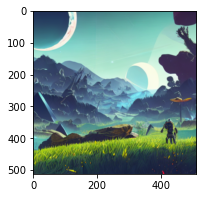

0it [00:00, ?it/s]

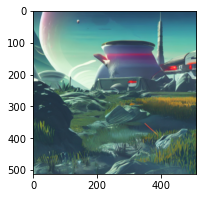

0it [00:00, ?it/s]

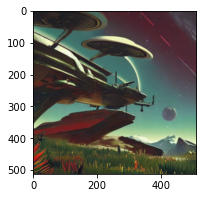

0it [00:00, ?it/s]

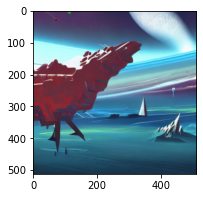

"no mans sky concept art" - StableDiffusion v1.4


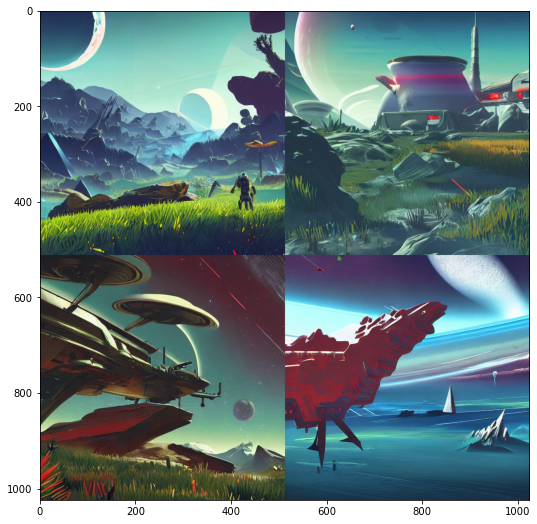

In [21]:
# # example standalone call
# generate_images("no mans sky concept art", 
#                 steps=50, 
#                 guidance=7.5, 
#                 grid_size=(2, 2), 
#                 seed=None)

In [ ]:
# based in part on
# https://github.com/LearnDataSci/articles/tree/master/How%20to%20Stream%20Text%20Data%20from%20Twitch%20with%20Sockets%20in%20Python

In [8]:
# simple way to get oauth token is via https://twitchapps.com/tmi/ 
# however a more 'proper route would handle authorization itself'
# may have to update token every few months

# should probably change this to load from a txt config
# should also probably stop testing in production buuuuut *shrug*
server = 'irc.chat.twitch.tv'
port = 6667
nickname = '********'
token = 'oauth:*******************************'
channel = '#*********'

In [11]:
# could use GET https://api.twitch.tv/helix/users/follows?to_id=<user ID>
# or something along those lines to check for followers

textfile = os.getcwd()+ '\\'+ output_folder_name +'\\stream\\' + 'stream' + '.txt'
def apply_command(msg, user):    
    if msg[:9] == '!generate':
        # do checks for flags, steps, guidance, hw,
        prompt = msg[9:]
        print('found generate command!, prompt:', prompt)
        with open(textfile, 'w') as f:
            f.write("generating new images...")
        generate_images(prompt, steps=50, guidance=8.0, grid_size=(2, 2), seed=None)
        with open(textfile, 'w') as f:
            f.write("requested by: "+user)
            
    elif msg[:5] == '!del' or msg[:6] == '!clear':
        print('found delete command!, updating to blank image..')
        blank_image = Image.new('RGBA', size=(512, 512))
        save_image(blank_image, os.getcwd()+ '\\'+ output_folder_name +'\\' + 'stream' + '.png', overwrite=True)
        with open(textfile, 'w') as f:
            f.write("")
        
    elif msg[:10] == '!terminate' and user == nickname:
        return True
    else:
        print(msg, 'command not found')
    return False
        
    
    # todo: add commands for deleting, selecting from grid, regenerate same prompt, possibly check user privs
    # possibly some sort of saved queue, allowing for !previous !next type thing to scroll through
    # or default to slideshow after a period of time

In [ ]:
sock = socket.socket()
sock.connect((server, port))
sock.settimeout(1.0)

sock.send(f"PASS {token}\n".encode('utf-8'))
sock.send(f"NICK {nickname}\n".encode('utf-8'))
sock.send(f"JOIN {channel}\n".encode('utf-8'))

while True:
    try:
        resp = sock.recv(2048).decode('utf-8')
        print(resp)

        if resp.startswith('PING'):
            sock.send("PONG\n".encode('utf-8'))
            print('ponged server ping')

        elif len(resp) > 0:
            last_msg = demojize(resp)
            attempt_msg_deconstruct = re.search(':(.*)\!.*@.*\.tmi\.twitch\.tv PRIVMSG #(.*) :(.*)', last_msg)
            if attempt_msg_deconstruct is not None:
                user, chl, msg = attempt_msg_deconstruct.groups()
                print(user) # , ':', msg)
                if msg[0] == '!':
                    error = apply_command(msg, user)
                    if error: 
                        apply_command('!clear', nickname)
                        break
    except socket.timeout:
        continue # probs should do something here
    except ConnectionAbortedError:
        continue # probs should do something here
    except KeyboardInterrupt:
        print('closing connection...')
        sock.close()
        break
print('closing connection...')
sock.close()